<a href="https://colab.research.google.com/github/robinvvinod/spaceapps/blob/master/CSSE_timeseries_agglomerative_clustering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!rm -rf /content/spaceapps
!pip install geopandas
!pip install pyshp
!pip install shapely==1.6.3
!pip install plotly-geo
!pip install plotly
!pip install folium
!pip install branca
!git clone https://github.com/robinvvinod/spaceapps.git
!pip install nasapy

Cloning into 'spaceapps'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 313 (delta 50), reused 62 (delta 22), pack-reused 187
Receiving objects: 100% (313/313), 15.43 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [0]:
import pandas as pd
import plotly
import branca
import requests
from matplotlib import pyplot as plt
from collections import OrderedDict, defaultdict, Counter
import seaborn as sns
import numpy as np
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs, load_iris
import os
import folium



viridis_color_scheme = ["#f2fffc", "#c1fef3", "#90ffea", "#5fffe0", "#2effd7", "#00fccd", "#00cca5", "#009b7d", "#006a55", "#00392e"]


In [76]:
testing = pd.read_csv("/content/spaceapps/testingrates/testing_rates_county.csv").drop(columns=['Unnamed: 0']).rename(columns={"fips": "FIPS"})
reference = pd.read_csv("/content/spaceapps/JHU_data/time_series_covid19_confirmed_US_CSSE_clean.csv")
confirmed =  pd.read_csv("/content/spaceapps/covidstats/confirmed_cases_county_cumulative.csv").drop(columns=['Unnamed: 0']).rename(columns={"fips": "FIPS"})
deaths =  pd.read_csv("/content/spaceapps/covidstats/deaths_county_cumulative.csv").drop(columns=['Unnamed: 0']).rename(columns={"fips": "FIPS"})
demographics = pd.read_csv("/content/spaceapps/countydemographics/county_demographics.csv").drop(columns=['Unnamed: 0', 'county', 'state','state_code','male', 'female','median_age', 'female_percentage', 'lat', 'long','Density per square mile of land area']).rename(columns={"fips": "FIPS"})
locations = pd.read_csv("/content/spaceapps/countydemographics/county_demographics.csv").drop(columns=['Unnamed: 0','population', 'county', 'state','state_code','male', 'female','median_age', 'female_percentage','Density per square mile of land area']).rename(columns={"fips": "FIPS"})

def create_FIPS_lookup(df):
  lookup = df[["FIPS", "Combined_Key"]]
  return lookup.set_index("FIPS").T.to_dict()

def create_location_lookup(df):
  lookup = df[["FIPS", "lat", "long"]]
  return lookup.set_index("FIPS").T.to_dict()

def FIPS_to_name(FIPS, lookup):
  try:
    return LU[FIPS]["Combined_Key"]
  except:
    return "FIPS {} not found in lookup".format(FIPS)

LU = create_FIPS_lookup(reference)
LOC = create_location_lookup(locations)

confirmed = pd.merge(demographics, confirmed, left_on="FIPS", right_on="FIPS")
confirmed.iloc[0:, 2:] = confirmed.iloc[0:, 2:].div(confirmed.population, axis=0) * 100

deaths = pd.merge(demographics,deaths,  left_on="FIPS", right_on="FIPS")
deaths.iloc[0:, 2:] = deaths.iloc[0:, 2:].div(deaths.population, axis=0) * 100


locations.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning:

DataFrame columns are not unique, some columns will be omitted.



[32.534922932928126, -86.6427301373947]

In [67]:
confirmedT = confirmed.set_index('FIPS').drop(columns="population")
confirmedD = confirmedT.fillna(0)

confirmedD.head()

2020-01-22  2020-01-23  2020-01-24  ...  2020-05-26  2020-05-27  2020-05-28
FIPS                                      ...                                    
1001         0.0         0.0         0.0  ...    0.342391    0.347826    0.371377
1003         0.0         0.0         0.0  ...    0.133105    0.135507    0.135027
1005         0.0         0.0         0.0  ...    0.473198    0.504228    0.511985
1007         0.0         0.0         0.0  ...    0.292982    0.315177    0.315177
1009         0.0         0.0         0.0  ...    0.088473    0.091942    0.100616

[5 rows x 128 columns]

In [68]:
deathsT = deaths.set_index("FIPS").drop(columns="population")
deathsD = deathsT.fillna(0)

deathsD.head()

2020-01-22  2020-01-23  2020-01-24  ...  2020-05-26  2020-05-27  2020-05-28
FIPS                                      ...                                    
1001         0.0         0.0         0.0  ...    0.005435    0.005435    0.005435
1003         0.0         0.0         0.0  ...    0.004325    0.004325    0.004325
1005         0.0         0.0         0.0  ...    0.003879    0.003879    0.003879
1007         0.0         0.0         0.0  ...    0.004439    0.004439    0.004439
1009         0.0         0.0         0.0  ...    0.001735    0.001735    0.001735

[5 rows x 128 columns]

In [69]:
testingT = testing.set_index("FIPS")
testingD = testingT.fillna(0)
testingD.head()

2020-01-22  2020-01-23  2020-01-24  ...  2020-05-27  2020-05-28  2020-05-29
FIPS                                      ...                                    
1001         0.0         0.0         0.0  ...    0.000918    0.000923    0.000914
1003         0.0         0.0         0.0  ...    0.003462    0.003480    0.003445
1005         0.0         0.0         0.0  ...    0.000429    0.000431    0.000427
1007         0.0         0.0         0.0  ...    0.000375    0.000377    0.000373
1009         0.0         0.0         0.0  ...    0.000959    0.000964    0.000954

[5 rows x 129 columns]

In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def cluster_counties(model, df):
  clt = {}; clt2 = {}
  for L in np.unique(model.labels_):
    mask = np.where(model.labels_ == L, True, False)
    counties_in_cluster = df[mask].index
    clt[str(L)] = counties_in_cluster
  plt.bar(list(range(10)), [len(v) for v in clt.values()], color='g')
  return clt

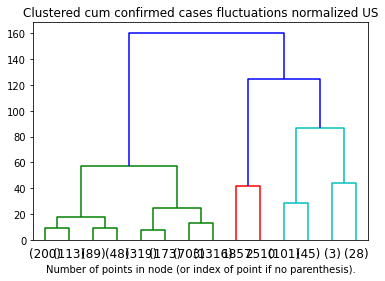

In [71]:
x = confirmedD.to_numpy()
cfm_model = AgglomerativeClustering(n_clusters=None, distance_threshold=10)
cfm_model = cfm_model.fit(x)


plt.title('Clustered cum confirmed cases fluctuations normalized US')
plot_dendrogram(cfm_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

cfm_model = AgglomerativeClustering(n_clusters=10).fit(x)


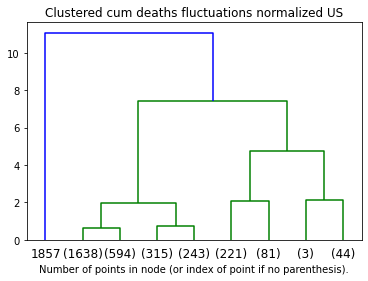

In [72]:
x = deathsD.to_numpy()
deaths_model = AgglomerativeClustering(n_clusters=None, distance_threshold=3)
deaths_model = deaths_model.fit(x)

plt.title('Clustered cum deaths fluctuations normalized US')
# plot the top three levels of the dendrogram
plot_dendrogram(deaths_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

deaths_model = AgglomerativeClustering(n_clusters=10).fit(x)

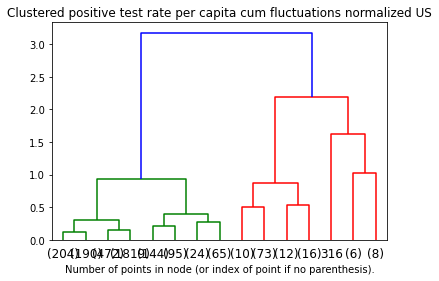

In [50]:
testingD = testingD.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
x = testingD.to_numpy()
testing_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.9)
testing_model = testing_model.fit(x)

plt.title('Clustered positive test rate per capita cum fluctuations normalized US')
# plot the top three levels of the dendrogram
plot_dendrogram(testing_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

testing_model = AgglomerativeClustering(n_clusters=10).fit(x)

CUMULATIVE FATALITIES


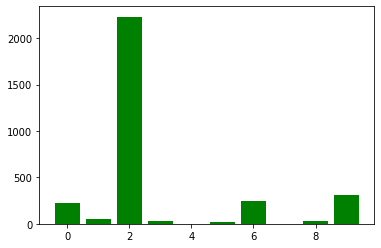

In [53]:
print("CUMULATIVE FATALITIES")
deaths_clt= cluster_counties(deaths_model, deathsD)

CUMULATIVE CASE COUNT CLUSTERS


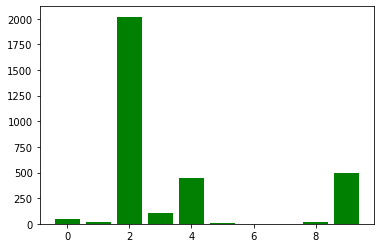

In [54]:
print("CUMULATIVE CASE COUNT CLUSTERS")
cfm_clt =  cluster_counties(cfm_model, confirmedD)

POSITIVE TEST RATE PER CAPITA CLUSTERS


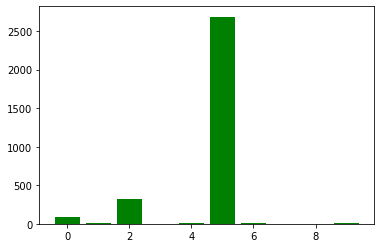

In [77]:
print("POSITIVE TEST RATE PER CAPITA CLUSTERS")
test_clt = cluster_counties(testing_model, testingD)

# Cluster Analysis

Once clustering has been accomplished, 

1. Classify risk spots by county criteria such as maximum or average daily case change 

2. Assign a severity scale (COVID Morbidity and COVID Mortality) to confirmed cases and deaths respectively. 

3. Using a scale of 1 to 10, divide confirmed cases and fatalities into 10 clusters. 

4. This arrangement starting from the county cluster with highest average cumulative mortality/morbidity and lowest average cumulative mortality/morbidity, and second highest (lowest) cluster is the county clusters with minimum average distance between clusters.
 - Thus assuming a radial heatmap from 'hotspots' and 'coldspots'

 5. Scores are allocated to counties based on their distance between the nearest cold and hot spot

In [0]:
# def make_dat_cake(x_df):
#   x = x_df.to_numpy()
#   model = AgglomerativeClustering(n_clusters=10).fit(x)
#   clusters = cluster_counties(model, x_df)

#   from plotly import figure_factory as ff
#   import json

#   all_fips = []
#   all_items = []

#   for k, v in cfm_clt.items():
#     items =  [(str(i), k) for i in v]
#     all_items = all_items + items

#   cfm_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

#   cfm_clusters.head()



#   return clusters_w_date

## Confirmed Cases

In [79]:
from plotly import figure_factory as ff
import json


all_fips = []
all_items = []

for k, v in cfm_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

cfm_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

cfm_clusters.head()

FIPS Cluster
0  1013       0
1  1085       0
2  4001       0
3  5123       0
4  8075       0

In [80]:
# topo = json.loads(requests.get(county_geo).text)
# cfm_clusters_series = cfm_clusters.set_index('FIPS')

latest_date_cases = confirmed[["FIPS",confirmed.columns[-1]]]
latest_date_cases = pd.DataFrame(latest_date_cases).rename({"FIPS":"FIPS"})
cfm_clusters2 = cfm_clusters.rename({"FIPS": "FIPS"})

latest_date_cases["FIPS"] = latest_date_cases["FIPS"].astype(str)
cfm_clusters2["FIPS"] = cfm_clusters2["FIPS"].astype(str)

cfm_clusters2 = cfm_clusters2.set_index("FIPS")
latest_date_cases = latest_date_cases.set_index("FIPS")

cluster_finaldate = pd.merge( cfm_clusters2, latest_date_cases, left_index=True, right_index=True)
print(cluster_finaldate)

cluster_finaldate["Cluster"] = cluster_finaldate["Cluster"].astype(int)

date = cluster_finaldate.columns[-1]

mean_cases_per_cluster = {}
for c in list(range(10)):
  temp = cluster_finaldate[cluster_finaldate.Cluster == c]
  mean_cases_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_cases_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])
print(cluster_assignment)

cfm_clusters['Cluster'] = cfm_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])

print(cfm_clusters)

      Cluster  2020-05-28
FIPS                     
1013        0    1.957553
1085        0    2.168816
4001        0    1.803641
5123        0    2.510078
8075        0    2.697220
...       ...         ...
55127       9    0.361119
56009       9    0.171465
56019       9    0.211392
56021       9    0.192442
56043       9    0.430557

[3140 rows x 2 columns]
{7: 10, 6: 9, 5: 8, 1: 7, 8: 6, 0: 5, 3: 4, 4: 3, 9: 2, 2: 1}
       FIPS  Cluster
0      1013        5
1      1085        5
2      4001        5
3      5123        5
4      8075        5
...     ...      ...
3135  55127        2
3136  56009        2
3137  56019        2
3138  56021        2
3139  56043        2

[3140 rows x 2 columns]


In [88]:
cfm_clusters_w_name = cfm_clusters
cfm_clusters_w_name["County"] = cfm_clusters["FIPS"].apply(lambda x: LU[int(x)]["Combined_Key"])
cfm_clusters_w_name = cfm_clusters_w_name.set_index("FIPS")
cfm_clusters_w_name = pd.merge(cfm_clusters_w_name, latest_date_cases, right_index=True, left_index=True)
cfm_clusters_w_name = cfm_clusters_w_name.sort_values("Cluster", ascending=False)

latest = cfm_clusters_w_name.columns[-1]
cfm_clusters_w_name[latest] = cfm_clusters_w_name[latest].apply(lambda x: round(x,2))


cfm_clusters_w_name.to_csv("/content/clusters_by_confirmed_cases.csv")
cfm_clusters_w_name.head()

Cluster                       County  2020-05-28
FIPS                                                   
47169       10     Trousdale, Tennessee, US       14.55
36061        9  New York City, New York, US       12.32
5079         8        Lincoln, Arkansas, US        7.12
27105        8        Nobles, Minnesota, US        6.85
31043        8         Dakota, Nebraska, US        8.12

In [105]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlOrRd_09.scale(1, 10)
colormap.caption = "Ordered cluster number, (ascending) intracluster mean confirmed cases per capita"

top_counties = cfm_clusters_w_name.nlargest(10, columns=cfm_clusters_w_name.columns[-1])
print(top_counties.loc['47169'][-1])

latest_date = confirmed.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'

colorscale = branca.colormap.linear.YlOrRd_09.scale(1, 10)
cfm_clusters_series = cfm_clusters.set_index('FIPS')

def get_lat_long(fips):
  return list(LOC[int(fips)].values())

def style_function(feature):
    try:
      cluster_num = cfm_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }
    

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=2
)

for fip in list(top5_counties.index):
  folium.Marker(
      get_lat_long(fip),
      popup = "{}: {} %".format(top_counties.loc[fip]['County'], top_counties.loc[fip][-1])
  ).add_to(m)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

m

14.55


From here, we deduce that Cluster 2 is a 'coldspot' in terms of confirmed cases in the US while Clusters 6,4,2,9,8,0 might have 'hotspots' (we will discern one with other factors).

In [82]:
print(latest_date_cases)

       2020-05-28
FIPS             
1001     0.371377
1003     0.135027
1005     0.511985
1007     0.315177
1009     0.100616
...           ...
56037    0.058934
56039    0.433670
56041    0.058227
56043    0.430557
56045    0.014085

[3140 rows x 1 columns]


From here, we deduce that Cluster 2 is a 'coldspot' in terms of fatality cases in the US while Clusters 3,8,6,4 might be 'hotspots' (we will discern one with other factors).

## Fatality Cases

In [110]:
from plotly import figure_factory as ff
import json


all_fips = []
all_items = []

for k, v in deaths_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

deaths_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

deaths_clusters.head()

FIPS Cluster
0  1013       0
1  1063       0
2  1093       0
3  1111       0
4  1119       0

In [111]:
# topo = json.loads(requests.get(county_geo).text)
# cfm_clusters_series = cfm_clusters.set_index('FIPS')

latest_date_deaths = deaths[["FIPS",confirmed.columns[-1]]]
latest_date_deaths = pd.DataFrame(latest_date_deaths).rename({"FIPS":"FIPS"})
deaths_clusters2 = deaths_clusters.rename({"FIPS": "FIPS"})

latest_date_deaths["FIPS"] = latest_date_deaths["FIPS"].astype(str)
deaths_clusters2["FIPS"] = deaths_clusters2["FIPS"].astype(str)

deaths_clusters2 = deaths_clusters2.set_index("FIPS")
latest_date_deaths = latest_date_deaths.set_index("FIPS")

deaths_finaldate = pd.merge( deaths_clusters2, latest_date_deaths, left_index=True, right_index=True)
print(cluster_finaldate)

deaths_finaldate["Cluster"] = deaths_finaldate["Cluster"].astype(int)

date = deaths_finaldate.columns[-1]

mean_deaths_per_cluster = {}
for c in list(range(10)):
  temp = deaths_finaldate[deaths_finaldate.Cluster == c]
  mean_deaths_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_deaths_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])
print(cluster_assignment)

deaths_clusters['Cluster'] = deaths_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])

print(deaths_clusters)

       Cluster  2020-05-28
FIPS                      
1013         0    1.957553
1085         0    2.168816
4001         0    1.803641
5123         0    2.510078
8075         0    2.697220
...        ...         ...
55127        9    0.361119
56009        9    0.171465
56019        9    0.211392
56021        9    0.192442
56043        9    0.430557

[3140 rows x 2 columns]
{7: 10, 4: 9, 5: 8, 3: 7, 8: 6, 1: 5, 0: 4, 6: 3, 9: 2, 2: 1}
       FIPS  Cluster
0      1013        4
1      1063        4
2      1093        4
3      1111        4
4      1119        4
...     ...      ...
3135  55059        2
3136  55101        2
3137  55105        2
3138  55127        2
3139  56019        2

[3140 rows x 2 columns]


In [114]:
deaths_clusters_w_name = deaths_clusters
deaths_clusters_w_name["County"] = deaths_clusters["FIPS"].apply(lambda x: LU[int(x)]["Combined_Key"])
deaths_clusters_w_name = deaths_clusters_w_name.set_index("FIPS")
deaths_clusters_w_name = pd.merge(deaths_clusters_w_name, latest_date_deaths, right_index=True, left_index=True)
deaths_clusters_w_name = deaths_clusters_w_name.sort_values("Cluster", ascending=False)


latest = deaths_clusters_w_name.columns[-1]
deaths_clusters_w_name[latest] = deaths_clusters_w_name[latest].apply(lambda x: round(x,5))


deaths_clusters_w_name.to_csv("/content/clusters_by_fatalities.csv")
deaths_clusters_w_name.head()

Cluster                       County  2020-05-28
FIPS                                                   
36061       10  New York City, New York, US     1.31181
13099        9           Early, Georgia, US     0.28991
13243        9        Randolph, Georgia, US     0.26810
13273        9         Terrell, Georgia, US     0.29349
13095        8       Dougherty, Georgia, US     0.15816

In [118]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlGn_09.scale(1,10)
colormap.caption = "Ordered cluster number, (ascending) intracluster mean fatalities per capita"

top_counties = deaths_clusters_w_name.nlargest(10, columns=deaths_clusters_w_name.columns[-1])
latest_date = deaths.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'

colorscale = colormap
deaths_clusters_series = deaths_clusters.set_index('FIPS')


def style_function(feature):
    try:
      cluster_num = deaths_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }

NY_latlong = [40.7128, 74.0060]

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=5
)

for fip in list(top_counties.index):
  folium.Marker(
      get_lat_long(fip),
      popup = "{}: {} %".format(top_counties.loc[fip]['County'], top_counties.loc[fip][-1])
  ).add_to(m)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

m

## Testing 

In [0]:
from plotly import figure_factory as ff
import json


all_fips = []
all_items = []

for k, v in test_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

testing_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

testing_clusters.head()

In [0]:
# topo = json.loads(requests.get(county_geo).text)
# cfm_clusters_series = cfm_clusters.set_index('FIPS')

latest_date_testing = testing[["FIPS",confirmed.columns[-1]]]
latest_date_testing = pd.DataFrame(latest_date_testing).rename({"FIPS":"FIPS"})
testing_clusters2 = testing_clusters.rename({"FIPS": "FIPS"})

latest_date_testing["FIPS"] = latest_date_testing["FIPS"].astype(str)
testing_clusters2["FIPS"] = testing_clusters2["FIPS"].astype(str)

testing_clusters2 = testing_clusters2.set_index("FIPS")
latest_date_testing = latest_date_testing.set_index("FIPS")

testing_finaldate = pd.merge( testing_clusters2, latest_date_testing, left_index=True, right_index=True)
print(cluster_finaldate)

testing_finaldate["Cluster"] = testing_finaldate["Cluster"].astype(int)

date = testing_finaldate.columns[-1]

mean_testing_per_cluster = {}
for c in list(range(10)):
  temp = testing_finaldate[testing_finaldate.Cluster == c]
  mean_testing_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_testing_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])
print(cluster_assignment)

testing_clusters['Cluster'] = testing_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])
testing_finaldate['Cluster'] = testing_finaldate['Cluster'].apply(lambda x: cluster_assignment[int(x)])
print(testing_clusters)

In [0]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlGn_09.scale(1,10)
colormap.caption = "Ordered cluster number, (ascending) intracluster mean positive testing rate"

latest_date = confirmed_raw.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'


colorscale = colormap
testing_clusters_series = testing_clusters.set_index('FIPS')


def style_function(feature):
    try:
      cluster_num = testing_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }
    

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=2
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

m

In [0]:
testing_finaldate

In [0]:
testing_clusters_w_name = testing_clusters
testing_clusters_w_name["County"] = testing_clusters["FIPS"].apply(lambda x: LU[int(x)])
testing_clusters_w_name = testing_clusters_w_name.set_index("FIPS")
testing_clusters_w_name = pd.merge(testing_clusters_w_name, latest_date_deaths, right_index=True, left_index=True)
testing_clusters_w_name = testing_clusters_w_name.sort_values("Cluster", ascending=False)

latest = testing_clusters_w_name.columns[-1]
testing_clusters_w_name[latest] = testing_clusters_w_name[latest].apply(lambda x: round(x,5))

testing_clusters_w_name.head()
testing_clusters_w_name.to_csv("/content/clusters_by_ptr.csv")

## Extra Case: Average Mobility (Walking, Transit, Driving)

In [0]:
mobility_US = pd.read_csv("/content/spaceapps/applemobilitydata/applemobilitycleaned_county.csv").drop(columns=["region", "sub-region", "Unnamed: 0"])
mobility_US = mobility_US.dropna()
mobility_US["fips"] =  mobility_US["fips"].astype('int')
mobility_US = mobility.rename(columns={"fips":"FIPS"}).set_index("FIPS")

mobility_US.head()

In [0]:
x = mobility_US.to_numpy()
mob_model = AgglomerativeClustering(n_clusters=None, distance_threshold=10)
mob_model = mob_model.fit(x)


plt.title('Clustered cum confirmed cases fluctuations normalized US')
plot_dendrogram(mob_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

mob_model = AgglomerativeClustering(n_clusters=10).fit(x)


In [0]:
mobility_US.head()

In [0]:
print("CUMULATIVE CASE COUNT CLUSTERS")
mob_clt =  cluster_counties(mob_model, mobility_US)

In [0]:
temp = []

for k, v in mob_clt.items():
  v = v.dropna()
  v = v.astype(int)
  temp.append((k,v))

mob_clt = dict(temp)

mob_clt

In [0]:
from plotly import figure_factory as ff
import json

all_fips = []
all_items = []

for k, v in mob_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

mob_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

mob_clusters.head()

In [0]:
mob_clusters2 = mob_clusters
latest_date_mobilties = mobility_US[[mobility_US.columns[-1]]]
latest_date_mobilties = pd.DataFrame(latest_date_mobilties)

cluster_finaldate = pd.merge( mob_clusters2, latest_date_mobilties, left_index=True, right_index=True)
print(cluster_finaldate)

cluster_finaldate["Cluster"] = cluster_finaldate["Cluster"].astype(int)

date = cluster_finaldate.columns[-1]

mean_mobility_per_cluster = {}
for c in list(range(10)):
  temp = cluster_finaldate[cluster_finaldate.Cluster == c]
  mean_mobility_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_mobility_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])
print(cluster_assignment)

mob_clusters['Cluster'] = mob_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])

print(mob_clusters)

In [0]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlGn_09.scale(1,10)
colormap.caption = "Ordered cluster number, intracluster mean mobility (transit, cycling, walking)"

latest_date = mobility_US.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'


colorscale = colormap
def style_function(feature):
    print()
    try:
      mapping_value= mob_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(mapping_value)
    }
    except KeyError:
      mapping_value = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }
    

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=2
)


folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

## Extra Case: Predicted Cases


In [119]:
from plotly import figure_factory as ff
import json

predictions = pd.read_csv("/content/spaceapps/predictions/county_prediction_mapping.csv")
print(predictions.columns.to_list())
predictions = predictions.drop(columns=["Unnamed: 0"])
predictions.head()



['Unnamed: 0', 'fips', 'mapping']


fips   mapping
0  1001  0.110773
1  1003  0.086488
2  1005  0.078578
3  1007  0.043328
4  1009  0.000006

In [124]:
colormap = cm.linear.BuGn_03.scale(-1,1)
colormap.caption = "Predictions"

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'


colorscale = colormap

# num_counties_passed = 0
# num_counties_failed = 0
def style_function(feature):
    
    try:
      cluster_num = predictions.loc[feature["id"][-5:], :]["mapping"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      print(int(feature["id"][-5:]))
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }
    

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=5
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

# m.add_child(colormap)

m

1001
1009
1017
1021
1033
1045
1051
1065
1079
1083
1099
1107
1121
2050
2105
2122
2150
2164
2180
2188
2198
5141
5145
6005
6021
6033
6043
6055
6089
6099
6115
8003
8013
8014
8025
8031
8035
8047
12083
12087
12095
12111
12119
12125
13001
13013
13029
13043
13055
13059
13071
13079
13091
13107
13113
13123
8053
8057
8059
8073
8083
8095
8105
8111
8123
9015
12001
12013
12023
12039
12055
12059
12073
2261
2270
4003
4013
5001
5009
5019
5029
5043
5051
5061
5071
5085
5097
5101
5111
5123
5129
13309
13313
13319
15009
16015
16021
16045
16051
16057
16067
16081
17005
17009
17019
17029
17035
17049
17055
17065
18051
18059
18069
18079
18085
18095
18105
18115
18125
18131
18139
18153
18173
18179
18183
19009
19017
19021
19031
19039
17073
17077
17079
17089
17103
17107
17121
17129
17139
17145
17155
17169
17175
17179
17189
17203
18009
18011
18021
18033
13125
13129
13131
13139
13157
13169
13175
13187
13197
13201
13217
13225
13233
13243
13253
13265
13277
13285
13293
13303
20027
20029
20039
20049
20065
20075
20085
2009